# Cloud masking of multitemporal remote sensing images

This notebook focuses in the clustering process.

## Automatic selection of previous cloud-free images for the region of interest

### Set up

First, we need to initialize the GEE and import some functions. Then, we need to select an image to process from the Landsat 8 catalogue and also define a polygon which encloses our region of interest.

In [1]:
import ee

from datetime import datetime
from IPython.display import Image, display

from ee_ipl_uv import multitemporal_cloud_masking
from ee_ipl_uv import download
from ee_ipl_uv import time_series_show
from ee_ipl_uv import clustering
from ee_ipl_uv import normalization


ee.Initialize()

# Select image to remove clouds
image_index = "LC81990332015238LGN00"
image_predict_clouds = ee.Image('LANDSAT/LC8_L1T_TOA_FMASK/'+image_index)

# Select region of interest
pol = [[-0.50262451171875,39.39269330108945],
 [-0.267791748046875,39.38526381099777],
 [-0.26092529296875,39.54005788576377],
 [-0.501251220703125,39.53793974517628],
 [-0.50262451171875,39.39269330108945]]

region_of_interest = ee.Geometry.Polygon(pol)

In [2]:
# This will be hided (see metadata)
class Caption():
    num_figure = 1
    def __init__(self,s):
        self.s = s
        self.current_number = Caption.num_figure
        Caption.num_figure = Caption.num_figure+1 
    def _repr_html_(self):
        return '<center>Figure {0}. {1}</center>'.format(self.current_number,self.s)  

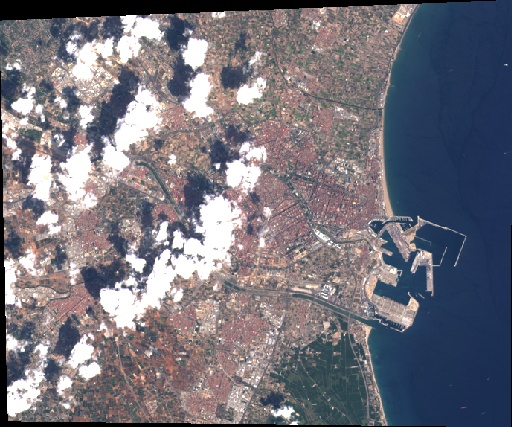

In [3]:
# Show image
image_file_original = download.MaybeDownloadThumb(image_predict_clouds.clip(region_of_interest),
                                                  params={"max":.3,"bands":"B4,B3,B2"})
display(Image(image_file_original),Caption('Clipped landsat 8 TOA image '+
                                           datetime.utcfromtimestamp(image_predict_clouds.get("system:time_start").getInfo()/1000).strftime("%Y-%m-%d %H:%M:%S")+
                                           ' over region of interest'))

## Automatic selection of previous cloud-free images

For each image of interest, we need to select a number (e.g. n=3) of past cloud-free images from the time series in order to build the model. The image of interest is $X_t \in \mathbb{R}(p \times B)$, where $p \equiv \text{number of pixels}$ and $B \equiv \text{number of bands}$ and the final input dataset is $X = [X_t,X_{t-1},X_{t-2},X_{t-3}]$, $X \in \mathbb{R}(p \times 4 \cdot B)$, where we define $X_{t-j}$ being  the $j$th previous image to $t$ without clouds. 

### Image selection 

The function `SelectImagesTraining` automatically selects the most recent images without clouds (`num_images`) within the current Landsat 8 image collection using the cloud cover calculated from the QABand. It creates a new image (image_with_lags) by stacking the cloudy image and the previous cloud-free images (e.g. max_lags=3).


In [4]:
# Select a number of scenes (max_lags) previous to the selected images and stack all those images together with this on bands
max_lags = 3
image_with_lags = multitemporal_cloud_masking.SelectImagesTraining(image_predict_clouds,
                                                                   region_of_interest=region_of_interest,
                                                                   num_images=max_lags)


#### Show selected images and its dates
`image_with_lags` contains the image of interest together with its previously selected cloud-free images (lags) from the time series. Properties of each image are included on the metadata. As an example we show how to provide the acquisition dates:

In [5]:
keys_time_stamps = ["system:time_start"]+["system:time_start_lag_"+str(lag) for lag in range(1,max_lags+1)]

# Print time stamps 
dictionary_server = {}
for prop in keys_time_stamps:
    dictionary_server[prop] = image_with_lags.get(prop)

dict_local = ee.Dictionary(dictionary_server).getInfo()

for prop in keys_time_stamps:
    dict_local[prop] = datetime.utcfromtimestamp(dict_local[prop]/1000)
    print("'"+prop+"'-> "+dict_local[prop].strftime("%Y-%m-%d %H:%M:%S"))

'system:time_start'-> 2015-08-26 10:43:24
'system:time_start_lag_1'-> 2015-08-10 10:43:16
'system:time_start_lag_2'-> 2015-08-10 10:42:52
'system:time_start_lag_3'-> 2015-08-03 10:37:03


And how to show the selected time series: 

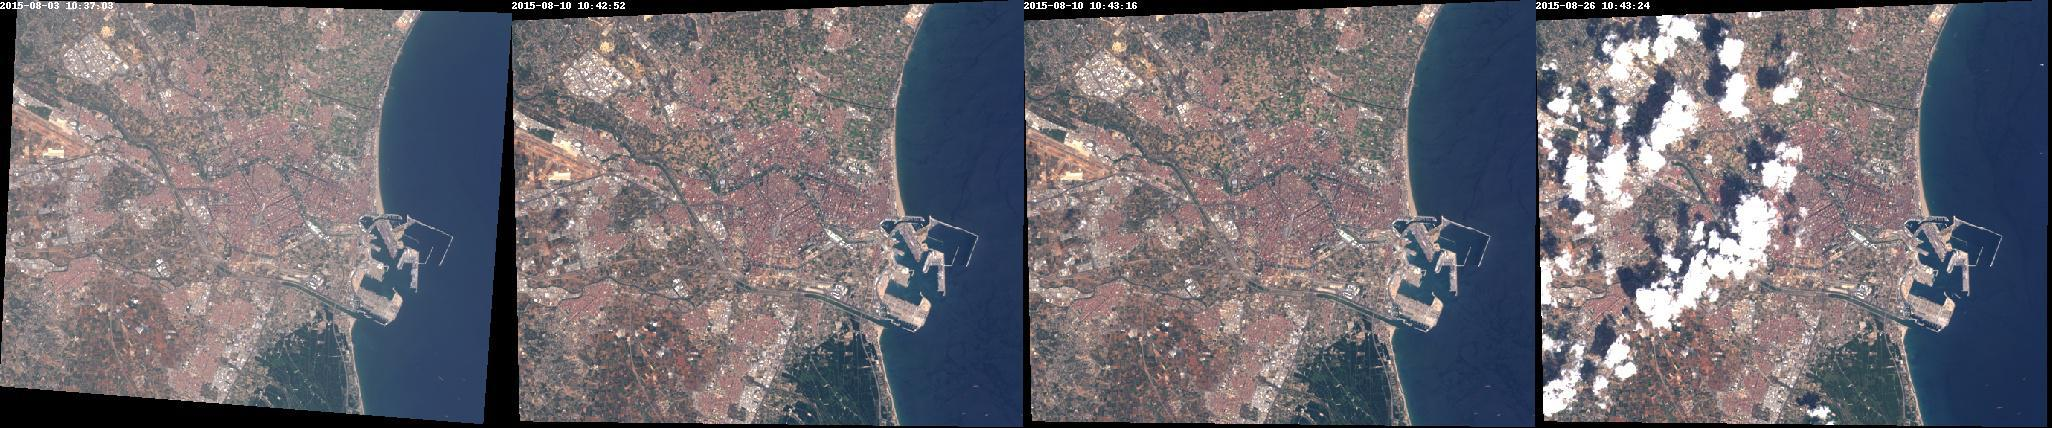

In [6]:
# Show "image": lag_3,lag_2,lag_1 and current image:
img_file = time_series_show.ShowLaggedThumbs(image_with_lags.clip(region_of_interest),
                                             range(0,max_lags+1),
                                             bands=["B4","B3","B2"],
                                             params={"max":.3})

display(Image(img_file),Caption(' Cloudy image to process (right) together with its '+
                                'chosen previous images sorted by time acquisition: '+
                                'lag_3 (left), lag_2 (second left), lag_1 (third left)'))

# Clustering the differences to create the cloud mask

We will perform a simple k-means clustering over the difference between the estimated image and the acquired image. First we form the difference image.

In [7]:
reflectance_bands_landsat8 = ["B%d"%i for i in range(1,12)]
reflectance_bands_landsat8_lag_1 = [i+"_lag_1" for i in reflectance_bands_landsat8]
img_differences = image_with_lags.select(reflectance_bands_landsat8).subtract(image_with_lags.select(reflectance_bands_landsat8_lag_1))

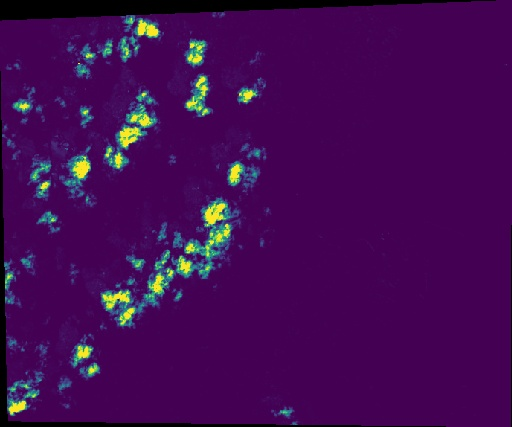

In [8]:
# Show norm of the visible bands:

norm_vis = img_differences.select(["B4","B3","B2"]).multiply(img_differences.select(["B4","B3","B2"])).reduce(ee.Reducer.mean())

viridis_palette =['440154','472c7a','3b518b','2c718e','21908d' ,'27ad81','5cc863','aadc32' ,'fde725']
image_file_norm_vis = download.MaybeDownloadThumb(norm_vis.clip(region_of_interest),
                                                  params={"min":0,"max":.3, 
                                                          "palette": ','.join(viridis_palette)})
display(Image(image_file_norm_vis),Caption("Differences on visible bands B2-B4"))

In [9]:
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import matplotlib.pyplot as plt
import numpy as np


color_sequence = ['1f77b4', 'ff7f0e', '2ca02c', 'd62728',
                              '9467bd', '8c564b', 'e377c2', '7f7f7f',
                              'bcbd22', '17becf']

def clusterleyend(nClusters):
    fig, ax = plt.subplots(1,1,figsize=(10,.5))
    cm = colors.ListedColormap(["#"+c for c in color_sequence])
    norm = colors.Normalize(vmin=0, vmax=nClusters)
    cb1 = colorbar.ColorbarBase(ax, cmap=cm,
                                    norm=norm,
                                    ticks=np.arange(.5,nClusters+.5),

                                    orientation="horizontal")

    _ = ax.set_xticklabels(np.arange(0,nClusters))
    return fig

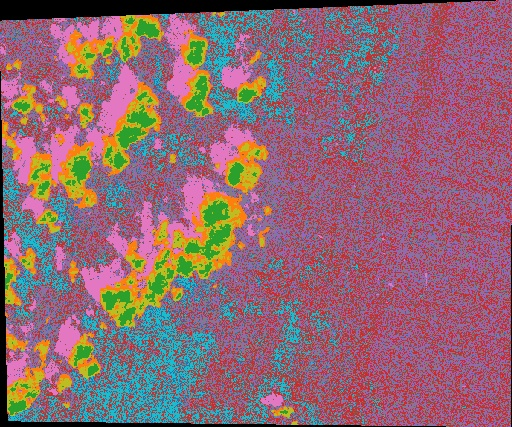

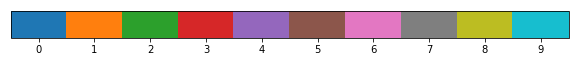

In [10]:
nClusters = 10
numPixels = 600
training = img_differences.sample(region=region_of_interest, scale=30, numPixels= numPixels)

training, media, std = normalization.ComputeNormalizationFeatureCollection(training, 
                                                                           reflectance_bands_landsat8)

clusterer = ee.Clusterer.wekaKMeans(nClusters).train(training)
img_differences_normalized = normalization.ApplyNormalizationImage(img_differences,
                                                                  reflectance_bands_landsat8,
                                                                  media,std)
result = img_differences_normalized.cluster(clusterer)

image_file_res_clust = download.MaybeDownloadThumb(result.clip(region_of_interest),
                                                   params={"min":0,"max":nClusters-1, 
                                                          "palette": ','.join(color_sequence)})

display(Image(image_file_res_clust),clusterleyend(nClusters),Caption("clusters over the differences"))

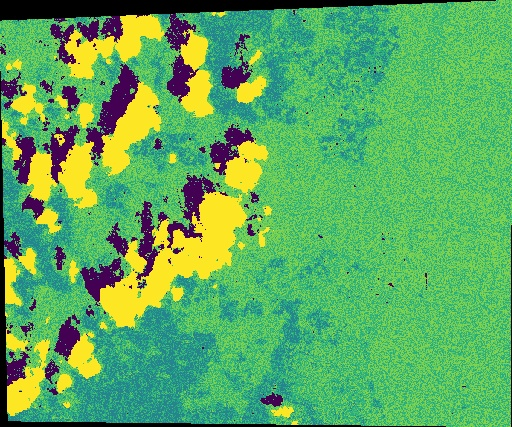

In [11]:

cloud_score = clustering.SelectClusters(img_differences,result,nClusters,region_of_interest)
THRESHOLD_SHADOW = .03
THRESHOLD_CLOUD = .09 

image_file_res_cloudscore = download.MaybeDownloadThumb(cloud_score.clip(region_of_interest),
                                                   params={"min":-THRESHOLD_SHADOW,
                                                           "max":THRESHOLD_CLOUD, 
                                                          "palette": ','.join(viridis_palette)}) 
 
display(Image(image_file_res_cloudscore),
        Caption("Cloud shadow clusterscore. Positive values over %.3f in yellow. Negative values below %.3f dark purple"%(THRESHOLD_CLOUD,THRESHOLD_SHADOW))) 

### Comparison with *fmask* cloud mask
We will visually compare our cloud-shadow mask with fmask cloud and shadow mask provided with the [Landsat 8 image collection](https://code.earthengine.google.com/dataset/LANDSAT/LC8_L1T_TOA_FMASK) in GEE, which includes the cloud mask from [Zhu, et al., 2012](http://www.sciencedirect.com/science/article/pii/S0034425711003853).

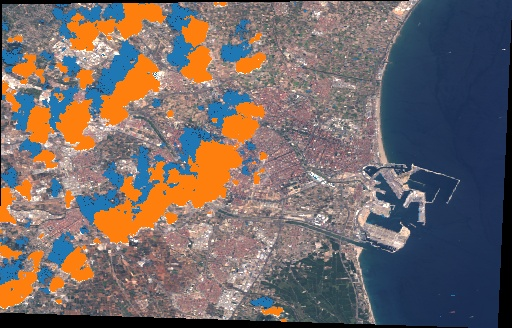

In [12]:
imageRGB = image_predict_clouds.visualize(max=.3,bands=["B4","B3","B2"])
cloud_score_threshold = cloud_score.gt(THRESHOLD_CLOUD).multiply(2)
cloud_score_threshold = cloud_score_threshold.add(cloud_score.lt(-THRESHOLD_SHADOW))
cloud_score_threshold = cloud_score_threshold.updateMask(cloud_score_threshold)
cloud_score_threshold_vis = cloud_score_threshold.visualize(max=2,min=1,palette=color_sequence[:2])
mosaic = ee.ImageCollection([imageRGB, cloud_score_threshold_vis]).mosaic()
mosaic_clouds_file = download.MaybeDownloadThumb(mosaic.clip(region_of_interest))

display(Image(mosaic_clouds_file),
        Caption("Thresholded cloud mask over rgb bands"))

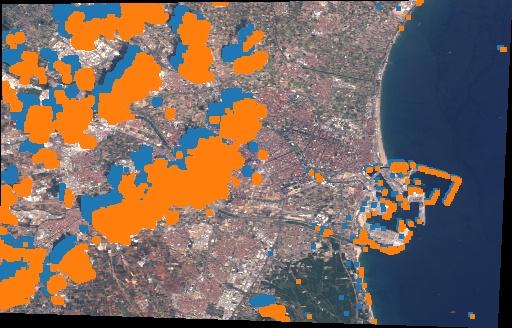

In [13]:
fmask_scored = image_predict_clouds.select("fmask").eq(4).multiply(2)
fmask_scored = fmask_scored.add(image_predict_clouds.select("fmask").eq(2))
fmask_scored = fmask_scored.updateMask(fmask_scored)
fmask_scored_vis = fmask_scored.visualize(max=2,min=1,palette=color_sequence[:2])
mosaic = ee.ImageCollection([imageRGB, fmask_scored_vis]).mosaic()
mosaic_fmask_file = download.MaybeDownloadThumb(mosaic.clip(region_of_interest))

display(Image(mosaic_fmask_file),
        Caption("FMask over rgb bands"))

Finally, this notebook shows an illustrative example but in order to check the proposed method, we have processed the whole year 2015 for the same region of interest. Results of the processed image time series are showed [here](http://isp.uv.es/projects/cdc/salida_4_10_9_3.html).